<a href="https://colab.research.google.com/github/musicjae/korean_sentiment_analysis/blob/master/gru_sentiment_analysis_modifying.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# References  
[1] # https://www.programcreek.com/python/example/106388/torchtext.data.Field
  
[2] https://simonjisu.github.io/nlp/2018/07/18/torchtext.html   

[3] https://wikidocs.net/44249


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import

In [ ]:
!git clone https://github.com/e9t/nsmc.git

Cloning into 'nsmc'...
remote: Enumerating objects: 14763, done.
remote: Total 14763 (delta 0), reused 0 (delta 0), pack-reused 14763
Receiving objects: 100% (14763/14763), 56.19 MiB | 17.17 MiB/s, done.
Resolving deltas: 100% (1749/1749), done.
Checking out files: 100% (14737/14737), done.


In [ ]:
!pip install konlpy

     |████████████████████████████████| 19.4MB 1.4MB/s 
     |████████████████████████████████| 460kB 43.0MB/s 
     |████████████████████████████████| 92kB 10.0MB/s 
  Found existing installation: tweepy 3.6.0
    Uninstalling tweepy-3.6.0:
      Successfully uninstalled tweepy-3.6.0
  Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3


In [ ]:
import pandas as pd
from konlpy.tag import Okt
from nltk import FreqDist
import numpy as np
from tqdm import tqdm
import random
import argparse
import torch

from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch
from torchtext import data
from torchtext.data import TabularDataset
from torchtext.data import Iterator
import warnings
warnings.filterwarnings(action='ignore')

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter

# default `log_dir` is "runs" - we'll be more specific here
writer = SummaryWriter('runs/fashion_mnist_experiment_1')

In [ ]:
random_seed=42
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
#torch.cuda.manual_seed_all(random_seed) # if use multi-GPU
#torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)
random.seed(random_seed)

# 새 섹션

# args

In [ ]:
USE_CUDA = torch.cuda.is_available()
print(USE_CUDA)

device = torch.device('cuda:0' if USE_CUDA else 'cpu')
print('학습을 진행하는 기기:',device)

parser = argparse.ArgumentParser(description='hyperparameters.....')
args = parser.parse_args("")

# =========== Training ============ #

args.batch_size = 128
args.epochs = 10
args.lr = 1e-3
args.eps = 1e-8
args.hidden_dim = 64
args.embbed_dim = 64
args.n_classes = 1
args.dropout_p = 0.2
args.n_layers = 1
args.patience = 10

args.total_steps = 1055 * args.epochs  # 총 훈련 스텝 =  배치반복 횟수 * 에폭 where 1055 is len(train_loader)


False
학습을 진행하는 기기: cpu


# Dataset

In [ ]:
train_dt = pd.read_csv("nsmc/ratings_train.txt", sep='\t')
test_dt = pd.read_csv("nsmc/ratings_test.txt", sep='\t')

train_path = 'nsmc/ratings_train.txt'
test_path = 'nsmc/ratings_test.txt'

### Preprocessing

In [ ]:
def preprocess(text):

    text['document'] = text['document'].fillna(0)
    text['document'] = text['document'].str.replace(pat = r'[^ ㄱ-ㅣ가-힣]+', repl=r' ', regex=True) # 한글을 제외한 나머지 제거
    text['document'] = text['document'].str.replace(',','').astype(object)

    return text

train_dt = preprocess(train_dt)
test_dt = preprocess(test_dt)

In [ ]:
train_dt=train_dt[['document','label']]
print(len(train_dt))
test_dt=test_dt[['document','label']]

150000


In [ ]:
train_y = train_dt.label
test_y = test_dt.label

In [ ]:
len(test_y)

50000

### Custom Dataset

#### Tokenizing

In [ ]:
tok = Okt()
def preprocessing_sen(sen):
    stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']
    result=[]

    temp= tok.morphs(sen)
    result.append(temp)

    return result    

In [ ]:
def preprocessing_entirity(df):
    result = []
    for sen in tqdm(df.document):
        try:
            result.append(preprocessing_sen(sen))
        except:
            result.append('NaN')

    result = [x[0] for x in result]
    return result

processed_train = preprocessing_entirity(train_dt)
processed_test = preprocessing_entirity(test_dt)

100%|██████████| 50000/50000 [03:43<00:00, 223.98it/s]


In [ ]:
processed_train[0:2]

[['아', '더빙', '진짜', '짜증나네요', '목소리'],
 ['흠', '포스터', '보고', '초딩', '영화', '줄', '오버', '연기', '조차', '가볍지', '않구나']]

In [ ]:
processed_test[0:10]

[['굳', 'ㅋ'],
 [],
 ['뭐',
  '야',
  '이',
  '평점',
  '들',
  '은',
  '나쁘진',
  '않지만',
  '점',
  '짜',
  '리',
  '는',
  '더',
  '더욱',
  '아니잖아'],
 ['지루하지는', '않은데', '완전', '막장', '임', '돈', '주고', '보기', '에는'],
 ['만',
  '아니었어도',
  '별',
  '다섯',
  '개',
  '줬을텐데',
  '왜',
  '로',
  '나와서',
  '제',
  '심기',
  '를',
  '불편하게',
  '하죠'],
 ['음악', '이', '주가', '된', '최고', '의', '음악', '영화'],
 ['진정한', '쓰레기'],
 ['마치',
  '미국',
  '애니',
  '에서',
  '튀어나온듯',
  '한',
  '창의력',
  '없는',
  '로봇',
  '디자인',
  '부터가',
  '고개',
  '를',
  '젖게',
  '한다'],
 ['갈수록',
  '개판',
  '되가는',
  '중국영화',
  '유치하고',
  '내용',
  '없음',
  '폼',
  '잡다',
  '끝남',
  '말',
  '도',
  '안되는',
  '무기',
  '에',
  '유치한',
  '남무',
  '아',
  '그립다',
  '동사서독',
  '같은',
  '영화',
  '가',
  '이건',
  '류',
  '아',
  '류작',
  '이다'],
 ['이별',
  '의',
  '아픔',
  '뒤',
  '에',
  '찾아오는',
  '새로운',
  '인연',
  '의',
  '기쁨',
  '모든',
  '사람',
  '이',
  '그렇지는',
  '않네']]

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(processed_train)
#tokenizer.fit_on_texts(processed_test)

In [ ]:
tokenizer.fit_on_texts(processed_test)

In [ ]:
len(tokenizer.word_counts)

114516

 각 정수는 전체 훈련 데이터에서 등장 빈도수가 높은 순서대로 부여되었기 때문에, 높은 정수가 부여된 단어들은 등장 빈도수가 매우 낮다는 것을 의미합니다. 여기서는 빈도수가 낮은 단어들은 자연어 처리에서 배제하고자 합니다. 등장 빈도수가 3회 미만인 단어들이 이 데이터에서 얼만큼의 비중을 차지하는지 확인해봅시다.

- 단어 집합(vocabulary)의 크기 : 97871
  
- 등장 빈도가 2번 이하인 희귀 단어의 수: 65669
  
- 단어 집합에서 희귀 단어의 비율: 67.09750590062428
  
- 전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.108513935768472

#### Dataset

In [ ]:
vocab_size= 97871-2

In [ ]:
train = tokenizer.texts_to_sequences(processed_train)
test = tokenizer.texts_to_sequences(processed_test)

리뷰의 최대 길이 : 79
리뷰의 평균 길이 : 12.767146666666667


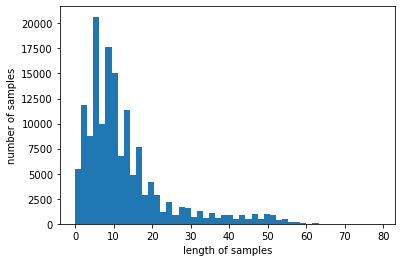

In [ ]:
print('리뷰의 최대 길이 :',max(len(l) for l in train))
print('리뷰의 평균 길이 :',sum(map(len, train))/len(train))
plt.hist([len(s) for s in train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [ ]:
print(train[0:2])
print(len(train))
print(len(test))

[[52, 435, 18, 6444, 627], [925, 445, 46, 581, 2, 201, 1465, 23, 939, 6445, 26099]]
150000
50000


#### Padding

In [ ]:
max_len = 30

train_X = train
eval_X = test[:25000]
test_X = test[25000:]

train_y = train_dt.label

test_y = test_dt.label
eval_y = test_y[:25000]
test_y = test_y[25000:]

train_X = pad_sequences(train_X, maxlen = max_len,padding='post')
eval_X = pad_sequences(eval_X, maxlen=max_len,padding='post')
test_X = pad_sequences(test_X, maxlen = max_len,padding='post')

In [ ]:
class mydataset(Dataset):

    def __init__(self,X,y):
        self.data = X
        self.target = y
       

    def __getitem__(self, index):

        x = self.data[index]
        y = self.target[index]

        return x,y

    def __len__ (self):

        return len(self.data)


In [ ]:
ctrain_set = mydataset(train_X,train_y)
ceval_set = mydataset(eval_X,eval_y)
ctest_set = mydataset(test_X,test_y)

In [ ]:
train_loader = DataLoader(ctrain_set,args.batch_size,shuffle=True)
eval_loader = DataLoader(ceval_set,args.batch_size)
test_loader = DataLoader(ctest_set,1)

print(len(train_loader.dataset))
print(len(eval_loader.dataset))
print(len(test_loader.dataset))

150000
25000
25000


# Model

In [ ]:
vocab_size = len(ctrain_set)


class GRU(nn.Module):
    def __init__(self, n_layers, hidden_dim, n_vocab, embed_dim, n_classes, dropout_p=0.2):
        super(GRU, self).__init__()
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim

        self.embed = nn.Embedding(n_vocab, embed_dim)
        self.dropout = nn.Dropout(dropout_p)
        self.gru = nn.GRU(embed_dim, self.hidden_dim,
                          num_layers=self.n_layers,
                          batch_first=True)
        self.out = nn.Linear(self.hidden_dim, n_classes)
        self.sigmoid = nn.Sigmoid()
        

    def forward(self, x):
        x = self.embed(x)
        h_0 = self._init_state(batch_size=x.size(0)) # 첫번째 히든 스테이트를 0벡터로 초기화
        x, _ = self.gru(x, h_0)  # GRU의 리턴값은 (배치 크기, 시퀀스 길이, 은닉 상태의 크기)
        h_t = x[:,-1,:] # (배치 크기, 은닉 상태의 크기)의 텐서로 크기가 변경됨. 즉, 마지막 time-step의 은닉 상태만 가져온다.
        self.dropout(h_t)
        logit = self.sigmoid(self.out(h_t))  # (배치 크기, 은닉 상태의 크기) -> (배치 크기, 출력층의 크기)

        return logit

    def _init_state(self, batch_size=1):
        weight = next(self.parameters()).data
        return weight.new(self.n_layers, batch_size, self.hidden_dim).zero_()


model = GRU(args.n_layers, args.hidden_dim, vocab_size, args.embbed_dim, args.n_classes, args.dropout_p)
print(model)

GRU(
  (embed): Embedding(150000, 64)
  (dropout): Dropout(p=0.2, inplace=False)
  (gru): GRU(64, 64, batch_first=True)
  (out): Linear(in_features=64, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [ ]:
class LSTM(nn.Module):
    def __init__(self, n_layers, hidden_dim, n_vocab, embed_dim, n_classes, dropout_p=0.2):
        super(LSTM, self).__init__()
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim

        self.embed = nn.Embedding(n_vocab, embed_dim)
        self.dropout = nn.Dropout(dropout_p)
        self.lstm = nn.LSTM(embed_dim, self.hidden_dim,
                          num_layers=self.n_layers,
                          batch_first=True)
        
        self.out = nn.Linear(self.hidden_dim, n_classes)
        self.sigmoid = nn.Sigmoid()
        

    def forward(self, x):
        x = self.embed(x)
        h_0 = self._init_state(batch_size=x.size(0)) # 첫번째 히든 스테이트를 0벡터로 초기화
        c_0 = self._init_state(batch_size=x.size(0))
        x, (h_out,_) = self.lstm(x, (c_0,h_0))  # GRU의 리턴값은 (배치 크기, 시퀀스 길이, 은닉 상태의 크기)
        self.dropout(h_t)
        logit = self.sigmoid(self.out(h_t))  # (배치 크기, 은닉 상태의 크기) -> (배치 크기, 출력층의 크기)

        return logit

    def _init_state(self, batch_size=1):
        weight = next(self.parameters()).data
        return weight.new(self.n_layers, batch_size, self.hidden_dim).zero_()



# Training

#### Ealry Stopping

In [ ]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""

    def __init__(self, patience=7, verbose=False):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            print(
                f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), 'checkpoint.pt')
        self.val_loss_min = val_loss

#### Train

In [ ]:
earlystop = EarlyStopping(patience=args.patience, verbose=True)

In [ ]:
model_path = '/content/drive/MyDrive/models'
optimizer = optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)
criterion = nn.BCELoss()

model.to(device)
train_losses=[]
val_losses = []
val_accuracies = []
avg_losses=[]
total_loss = 0

for epoch in range(args.epochs):

    model.train()
    for idx, batch in enumerate(train_loader):

        text = batch[0].to(torch.int64).to(device)
        label = batch[1].to(device).type(torch.float).unsqueeze(1)
        optimizer.zero_grad()

        output = model(text)
        loss = criterion(output,label)
        loss.backward()
        optimizer.step()

        if idx % 1000 == 0:
            print('Batch: %d      Loss: %5.5f' % (idx,loss))

    model.eval()
    corrects,val_loss = 0, 0
    for idx,batch in enumerate(eval_loader):
        
        text = batch[0].to(torch.int64).to(device)
        label = batch[1].to(device).type(torch.float).unsqueeze(1)
        
        output = model(text)
        val_loss = criterion(output, label)
        total_loss += val_loss.item()
        corrects += (output.max(1)[1].view(label.size()).data == label.data).sum()

    train_losses.append(loss)
    val_losses.append(val_loss)
        
    size = len(eval_loader.dataset)
    avg_loss = total_loss / size
    avg_losses.append(avg_loss)
    avg_accuracy = 100.0 * corrects / size
    print("===== epoch: %d   validation_avg_loss: %5.6f     validation_avg_accuracy:%5.2f ======" % (epoch,avg_loss,avg_accuracy))

    torch.save(model.state_dict(), '/content/drive/MyDrive/models/review sentiment analysis/txtclassification.pt')



Batch: 0      Loss: 0.69424
Batch: 1000      Loss: 0.41095
===== epoch: 0   validation_avg_loss: 0.003200     validation_avg_accuracy:49.81 ======
Batch: 0      Loss: 0.37406
Batch: 1000      Loss: 0.36227
===== epoch: 1   validation_avg_loss: 0.006130     validation_avg_accuracy:49.81 ======
Batch: 0      Loss: 0.25928


KeyboardInterrupt: ignored

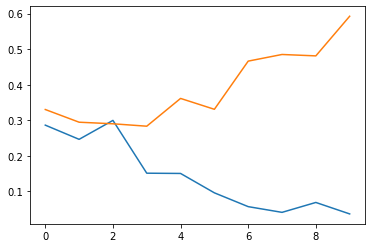

In [ ]:
plt.plot(train_losses)
plt.plot(val_losses)
plt.show()

# Test

1

In [ ]:
model_load_path = '/content/drive/MyDrive/models/review sentiment analysis/txtclassification.pt'
model.load_state_dict(torch.load(model_load_path))

model.eval()
corrects,val_loss = 0, 0
for idx,batch in enumerate(zip(test_loader.dataset.data,test_loader.dataset.target)):
    
    text = torch.Tensor(batch[0]).to(torch.int64).to(device).unsqueeze(1)
    print(text)
    label = torch.Tensor(batch[1]).to(torch.int64).to(device)
    print(label)
    
    #label = torch.ensor(batch[1]).to(device)
        
    output = model(text)
    val_loss = criterion(output, label)
    total_loss += val_loss.item()
    corrects += (output.max(1)[1].view(label.size()).data == label.data).sum()

tensor([[  48],
        [   1],
        [ 713],
        [4303],
        [2426],
        [   0],
        [   0],
        [   0],
        [   0],
        [   0],
        [   0],
        [   0],
        [   0],
        [   0],
        [   0],
        [   0],
        [   0],
        [   0],
        [   0],
        [   0],
        [   0],
        [   0],
        [   0],
        [   0],
        [   0],
        [   0],
        [   0],
        [   0],
        [   0],
        [   0]])
tensor([0])


ValueError: ignored

In [ ]:

def load_checkpoint(filepath):
    model.load_state_dict(torch.load(filepath))
    for parameter in model.parameters():
        parameter.requires_grad = False

    model.eval()
    return model

model = load_checkpoint(model_load_path)

In [ ]:
def sentiment_predict(model,new_sentence):
  new_sentence = tok.morphs(new_sentence) # 토큰화
  encoded = tokenizer.texts_to_sequences(new_sentence) # 정수 인코딩
  encoded = [[x[0] for x in encoded]]
  pad_new = pad_sequences(encoded, maxlen = max_len,padding='post') # 패딩
  pad_new = torch.FloatTensor(pad_new).to(torch.int64).to(device)

  print(pad_new)
  score = model(pad_new) # 예측
  score = score.item()
  print(score)
  if(score > 0.5):
    print("{:.2f}% 확률로 긍정 리뷰입니다.\n".format(score * 100))
  else:
    print("{:.2f}% 확률로 부정 리뷰입니다.\n".format((1 - score) * 100))


textin = '이 영화 노잼'
sentiment_predict(model,textin)

tensor([[  1,   2, 323,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0]])
0.006152578163892031
99.38% 확률로 부정 리뷰입니다.

